In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [3]:
image_data_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/patches'
labels_csv_path = '/content/drive/MyDrive/PreciousMD/STAN_patches_segs/labels/STAN_labels.csv'


In [4]:
labels_df = pd.read_csv(labels_csv_path)
print(labels_df.head())  # Display the first few rows of the labels dataframe


        UID  MUT_STATUS
0  SUB_0367           1
1  SUB_0368           0
2  SUB_0369           0
3  SUB_0370           0
4  SUB_0371           0


In [5]:
# List of patient IDs
patient_ids = os.listdir(image_data_path)
print(f"Total patients: {len(patient_ids)}")

Total patients: 116


## Ensure all patients in image folders have corresponding labels in the CSV file

In [6]:
# Get patient IDs from image folders
patient_ids_from_folders = set(os.listdir(image_data_path))

# Get patient IDs from the CSV file
patient_ids_from_csv = set(labels_df['UID'])

# Find patients in folders but not in CSV
missing_in_csv = patient_ids_from_folders - patient_ids_from_csv
if missing_in_csv:
    print(f"Patients present in folders but missing in CSV: {missing_in_csv}")
else:
    print("All patients in folders have corresponding labels in the CSV file.")

# Find patients in CSV but not in folders
missing_in_folders = patient_ids_from_csv - patient_ids_from_folders
if missing_in_folders:
    print(f"Patients present in CSV but missing in folders: {missing_in_folders}")
else:
    print("All patients in the CSV file have corresponding folders.")


All patients in folders have corresponding labels in the CSV file.
Patients present in CSV but missing in folders: {'SUB_0380'}


In [7]:
# Check for duplicates in the CSV file
duplicate_patients_in_csv = labels_df[labels_df['UID'].duplicated()]['UID']
if not duplicate_patients_in_csv.empty:
    print(f"Duplicate patient IDs in CSV: {duplicate_patients_in_csv.to_list()}")
else:
    print("No duplicate patient IDs in the CSV file.")

# Check for duplicate folders (this is unlikely since operating systems usually don't allow duplicate folder names, but it's good to double-check)
if len(patient_ids_from_folders) != len(os.listdir(image_data_path)):
    print("There might be duplicate folders. Please check manually.")
else:
    print("No duplicate folders detected.")


No duplicate patient IDs in the CSV file.
No duplicate folders detected.


In [8]:
# Check for duplicates in the CSV file
duplicate_patients_in_csv = labels_df[labels_df['UID'].duplicated()]['UID']
if not duplicate_patients_in_csv.empty:
    print(f"Duplicate patient IDs in CSV: {duplicate_patients_in_csv.to_list()}")
else:
    print("No duplicate patient IDs in the CSV file.")

# Check for duplicate folders (this is unlikely since operating systems usually don't allow duplicate folder names, but it's good to double-check)
if len(patient_ids_from_folders) != len(os.listdir(image_data_path)):
    print("There might be duplicate folders. Please check manually.")
else:
    print("No duplicate folders detected.")


No duplicate patient IDs in the CSV file.
No duplicate folders detected.


Given the results:

All patients in folders have corresponding labels in the CSV file:
This ensures that there won't be any "unlabeled" data issues when you proceed with training or validation. It means that every image you use will have an associated label.
Patients present in CSV but missing in folders: {'SUB_0380'}:
This indicates that while you have a label for patient SUB_0380, you do not have their image data. This discrepancy needs to be addressed before training.
Next Steps:

Address Missing Data: You need to decide how to address the missing image data for patient SUB_0380. Here are a few strategies:
a. Data Retrieval: If the missing data can be retrieved, locate the source of your dataset and check if the images for SUB_0380 were mistakenly excluded or misplaced.
b. Remove from CSV: If you can't retrieve the missing image data, it's best to remove the entry for SUB_0380 from the CSV file. This ensures consistency between your labels and data.

In [9]:
# Remove the SUB_0380 entry from the DataFrame
labels_df = labels_df[labels_df['UID'] != 'SUB_0380']


# Update the list of patient IDs to ensure it doesn't contain SUB_0380 and only includes IDs from the CSV that exist in the directory.
patient_ids = [pid for pid in os.listdir(image_data_path) if pid in labels_df['UID'].values]


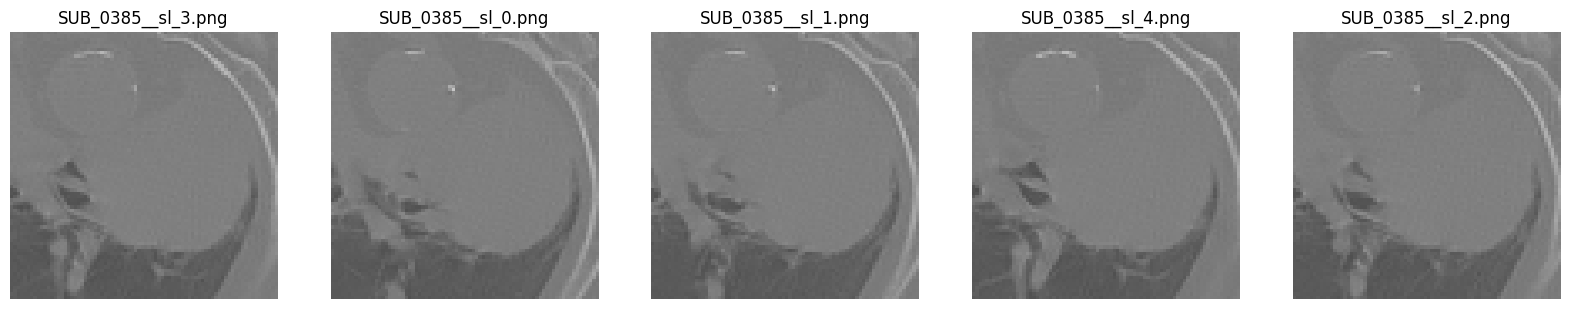

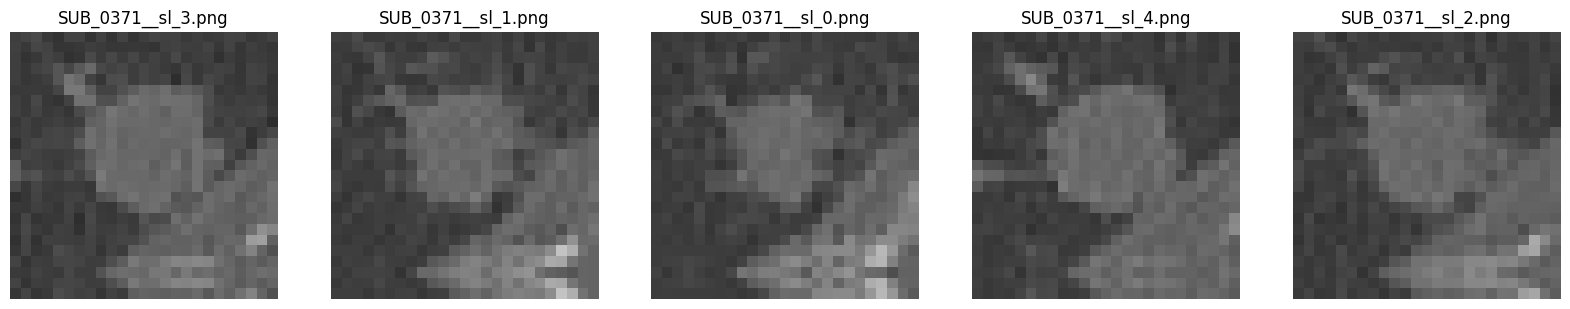

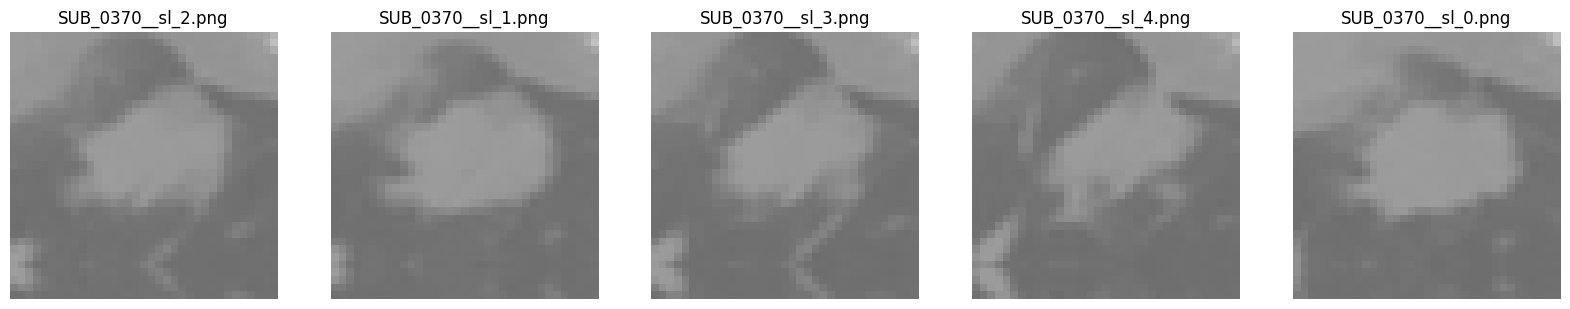

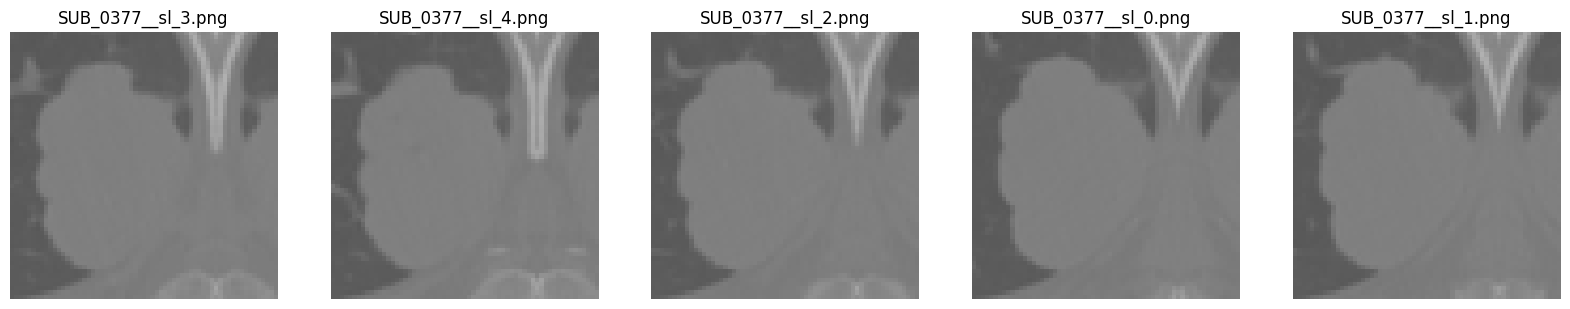

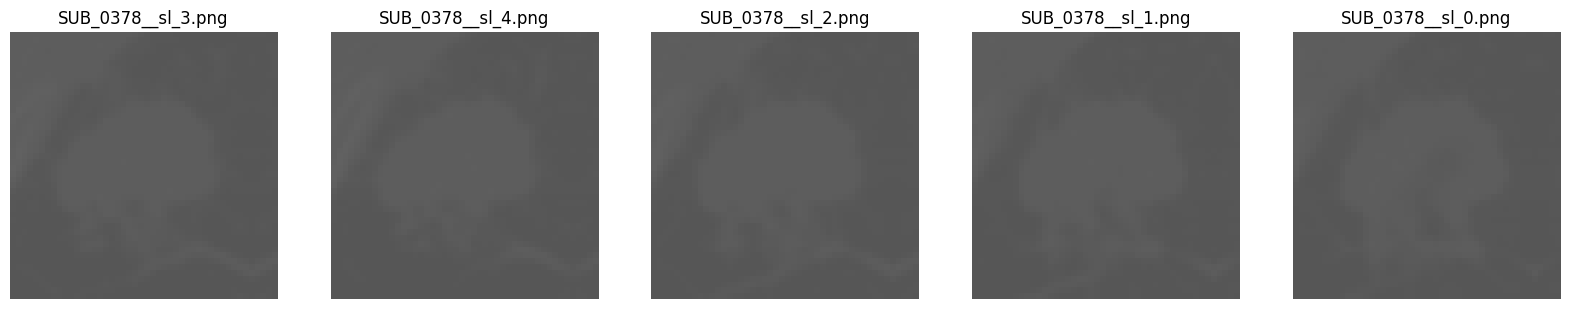

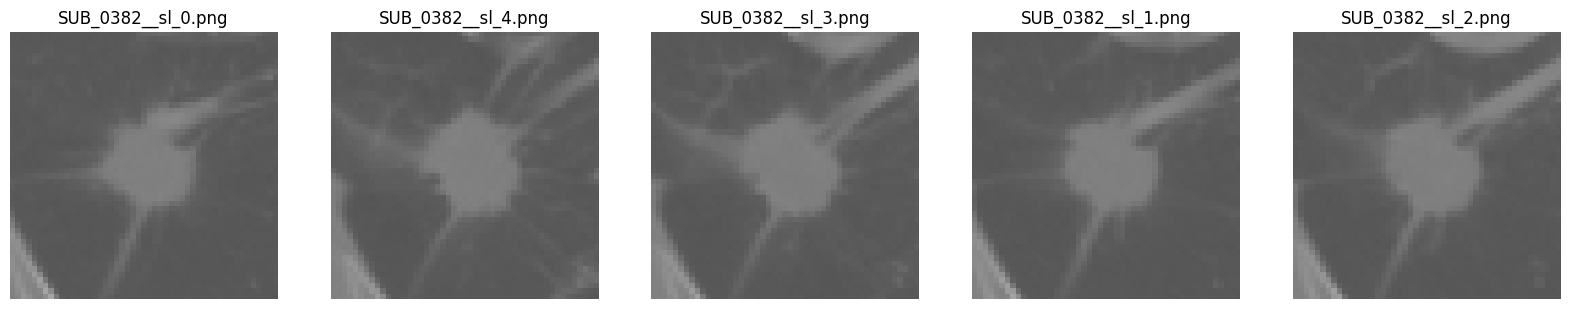

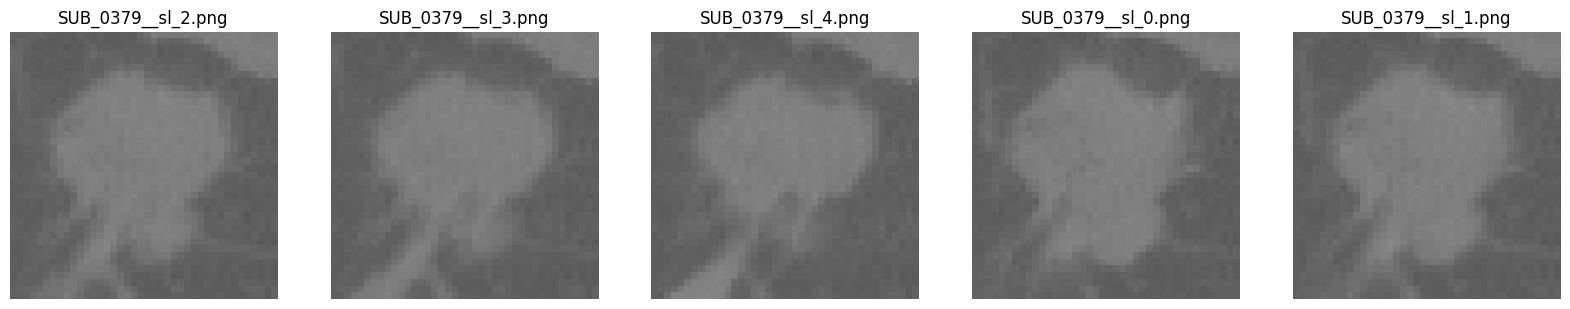

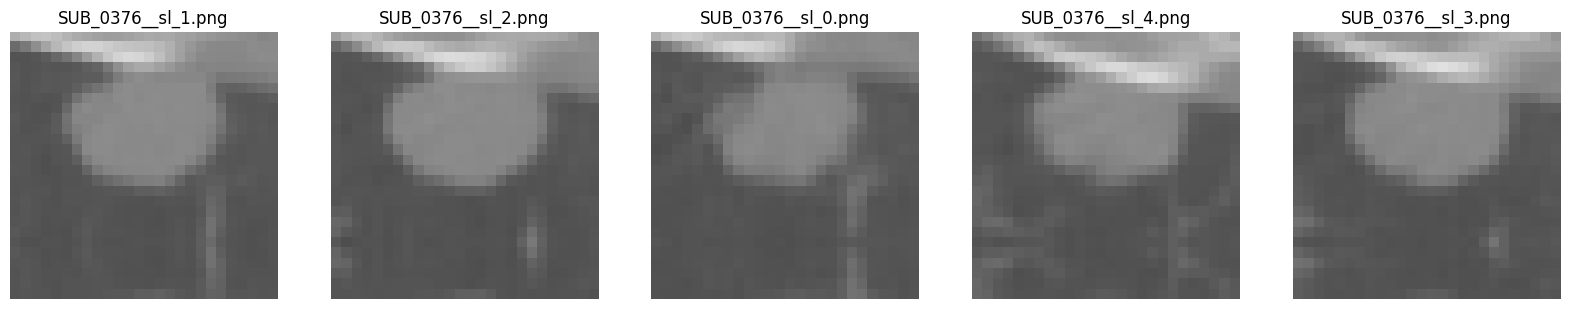

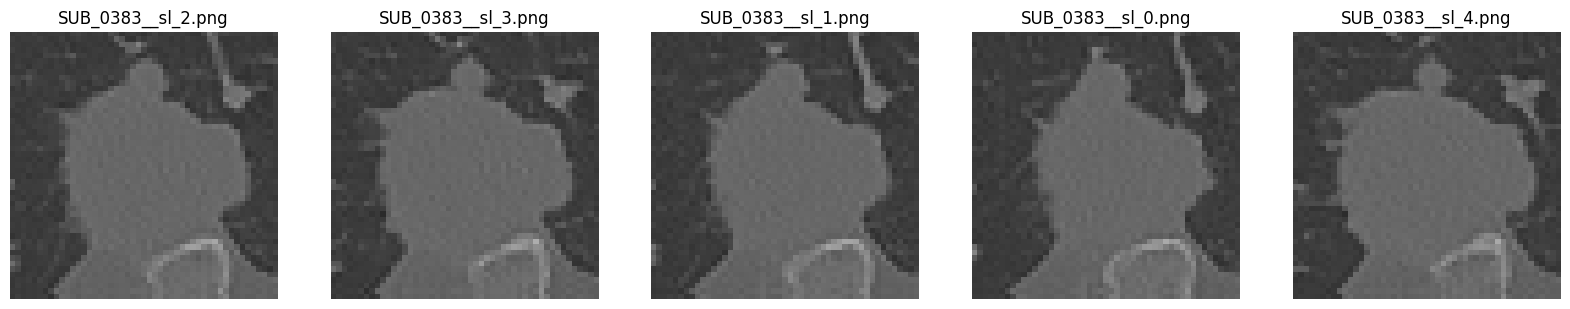

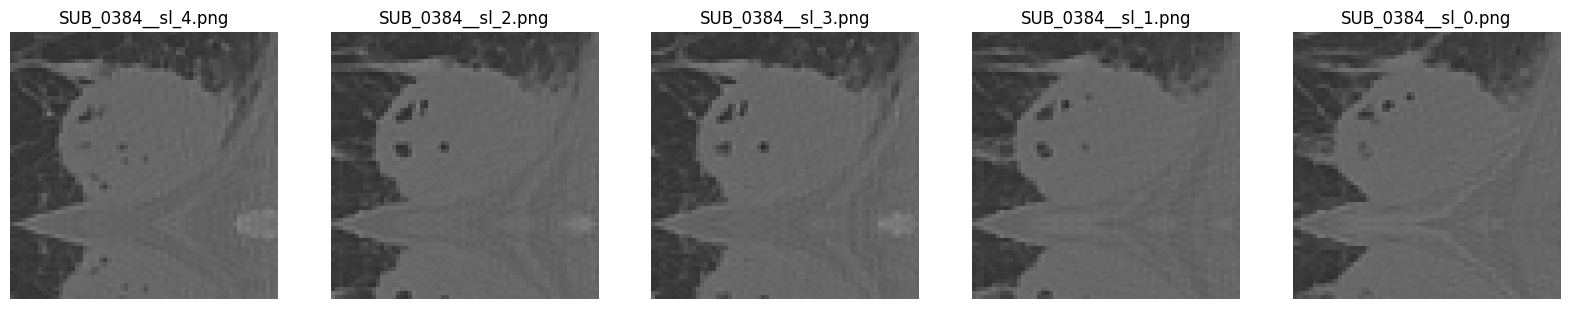

In [10]:
import cv2

def plot_images_for_patient(patient_id):
    patient_folder = os.path.join(image_data_path, patient_id)
    images = os.listdir(patient_folder)

    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    for i, image_file in enumerate(images[:5]):
        img_path = os.path.join(patient_folder, image_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].set_title(image_file)
        axs[i].axis('off')

# Plot images for a sample patient
for i in range(10):
  plot_images_for_patient(patient_ids[i])



0    93
1    23
Name: MUT_STATUS, dtype: int64
0    80.172414
1    19.827586
Name: MUT_STATUS, dtype: float64


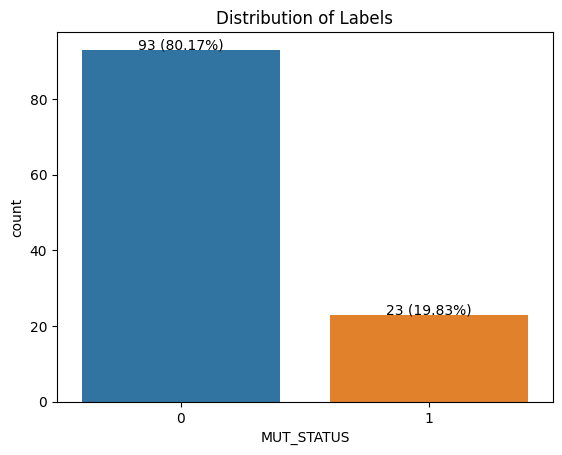

In [11]:
# Check the distribution of labels
label_distribution = labels_df['MUT_STATUS'].value_counts()
print(label_distribution)

# Get the distribution in percentages
label_distribution_percent = labels_df['MUT_STATUS'].value_counts(normalize=True) * 100
print(label_distribution_percent)

# Visualizing the distribution of labels along with counts
sns.countplot(x='MUT_STATUS', data=labels_df).set_title('Distribution of Labels')
for i, count in enumerate(label_distribution):
    plt.text(i, count, f'{count} ({label_distribution_percent.iloc[i]:.2f}%)', ha='center', va='baseline')
plt.show()

In [12]:
import numpy as np

# For simplicity, let's check the statistics for a single patient's images
patient_folder = os.path.join(image_data_path, patient_ids[0])
images = os.listdir(patient_folder)

pixel_values = []
for image_file in images:
    img_path = os.path.join(patient_folder, image_file)
    img = cv2.imread(img_path)
    pixel_values.extend(img.ravel())

pixel_values = np.array(pixel_values)
print(f"Mean: {np.mean(pixel_values)}, Std: {np.std(pixel_values)}, Min: {np.min(pixel_values)}, Max: {np.max(pixel_values)}")


Mean: 120.35284375, Std: 14.992430424653834, Min: 77, Max: 198


In [13]:
# Quick script to get the distribution of the number of images per patient
image_count_per_patient = {patient_id: len(os.listdir(os.path.join(image_data_path, patient_id))) for patient_id in labels_df['UID']}
image_count_distribution = pd.Series(image_count_per_patient).value_counts()
print(image_count_distribution)


5    116
dtype: int64


In [14]:
# Quick script to get unique image sizes across all patients
unique_image_sizes = set()
for patient_id in labels_df['UID']:
    patient_folder = os.path.join(image_data_path, patient_id)
    for img_name in os.listdir(patient_folder):
        img_path = os.path.join(patient_folder, img_name)
        img = Image.open(img_path)
        unique_image_sizes.add(img.size)
print(unique_image_sizes)


{(61, 61), (43, 43), (52, 52), (70, 70), (29, 29), (38, 38), (37, 37), (80, 80), (42, 42), (66, 66), (48, 48), (34, 34), (53, 53), (30, 30), (76, 76), (71, 71), (62, 62), (25, 25), (35, 35), (26, 26), (44, 44), (99, 99), (49, 49), (40, 40), (31, 31), (95, 95), (27, 27), (68, 68), (63, 63), (36, 36), (45, 45), (54, 54), (102, 102), (105, 105), (32, 32), (64, 64), (55, 55), (41, 41), (51, 51), (60, 60), (87, 87), (69, 69), (23, 23), (46, 46), (24, 24), (106, 106), (47, 47), (28, 28), (92, 92), (83, 83), (79, 79), (120, 120), (33, 33)}


## Histogram Analysis:
Given that you're dealing with tumors, the intensity distribution might reveal whether the image has good contrast between the tumor and the surrounding tissue. It might also indicate if the image is too dark or too bright.

In [15]:
def plot_histogram_for_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Grayscale for a simple histogram

    plt.hist(img.ravel(), bins=256, range=(0,256), fc='k', ec='k')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()


Patient ID: SUB_0423, Image: SUB_0423__sl_0.png


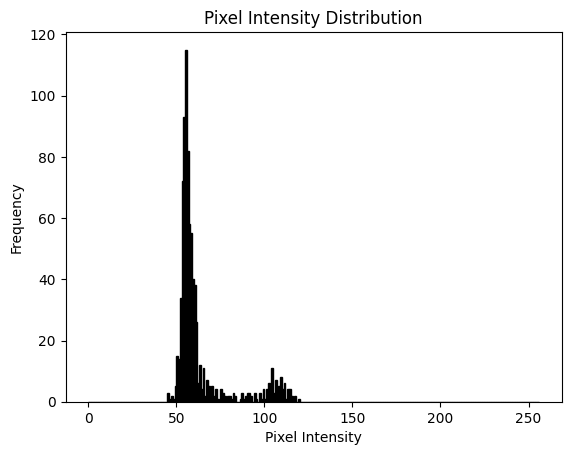

Patient ID: SUB_0470, Image: SUB_0470__sl_2.png


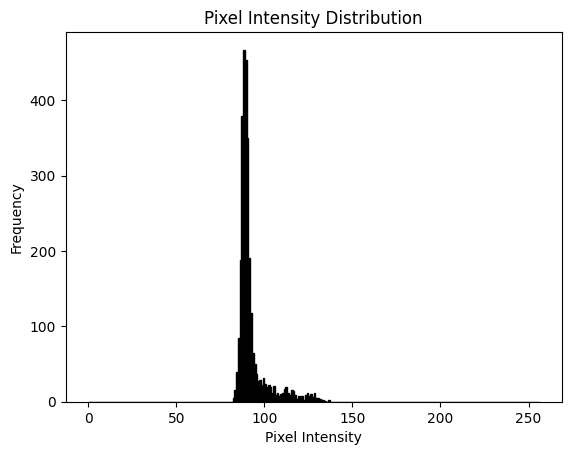

Patient ID: SUB_0427, Image: SUB_0427__sl_4.png


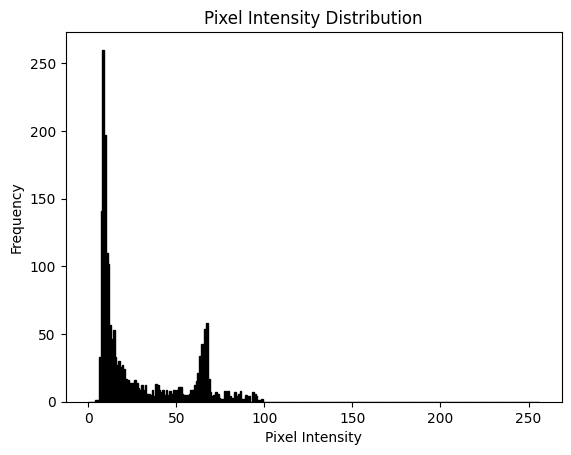

Patient ID: SUB_0437, Image: SUB_0437__sl_2.png


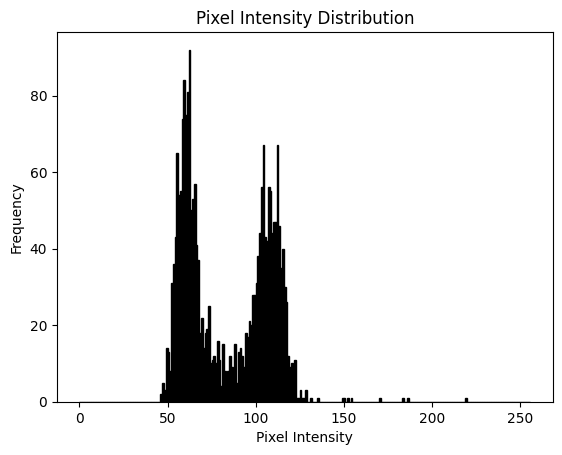

Patient ID: SUB_0394, Image: SUB_0394__sl_2.png


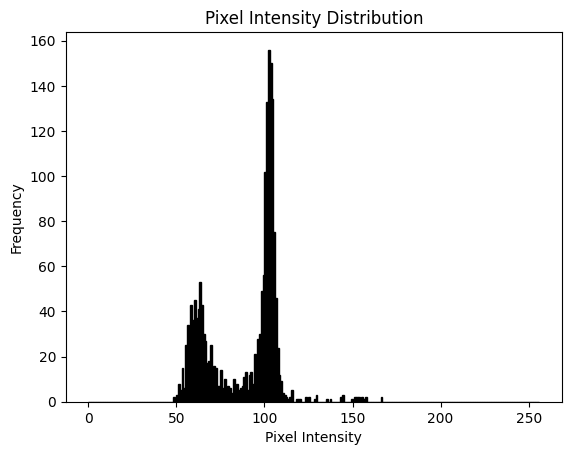

In [16]:
import random

sample_patient_ids = random.sample(patient_ids, 5)  # Sample 5 random patients

for patient_id in sample_patient_ids:
    patient_folder = os.path.join(image_data_path, patient_id)
    image_files = os.listdir(patient_folder)
    sample_image_file = random.choice(image_files)  # Sample one image from the patient
    image_path = os.path.join(patient_folder, sample_image_file)

    print(f"Patient ID: {patient_id}, Image: {sample_image_file}")
    plot_histogram_for_image(image_path)


# Using one image only

# Creating PyTorch Dataset

In [17]:
import random
from torch.utils.data import DataLoader
import torch
from torchvision import transforms

class TumorDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, labels_df, transform=None):
        self.image_folder = image_folder
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
      patient_id = self.labels_df.iloc[idx]['UID']
      label = self.labels_df.iloc[idx]['MUT_STATUS']

      patient_folder = os.path.join(self.image_folder, patient_id)
      image_files = os.listdir(patient_folder)
      image_path = os.path.join(patient_folder, image_files[0])

      image = Image.open(image_path).convert('RGB')

      if self.transform:
        image = self.transform(image)

      return image, label, patient_id  # Adding patient_id




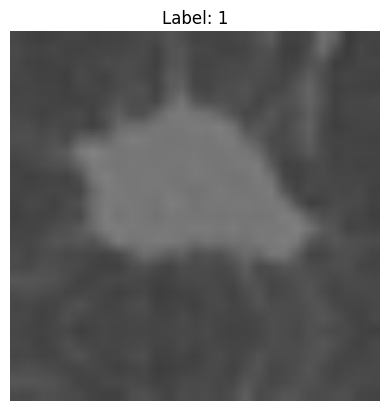

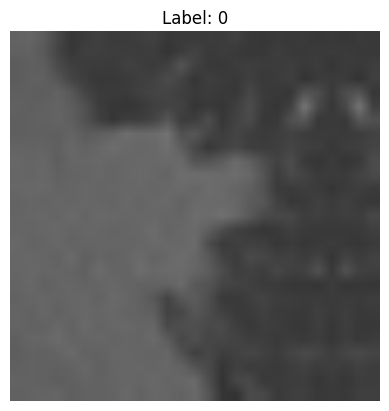

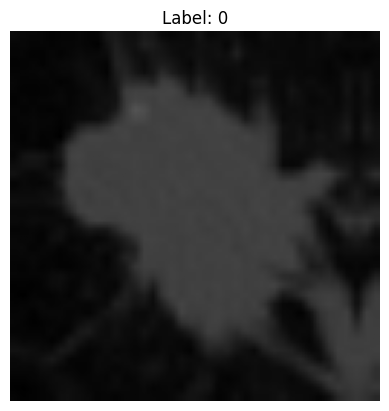

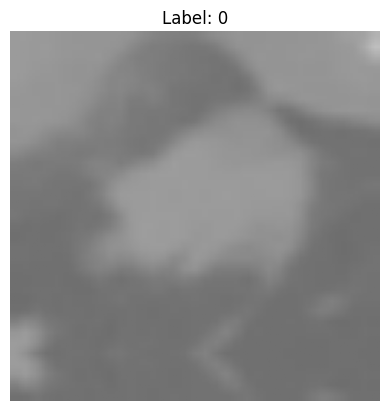

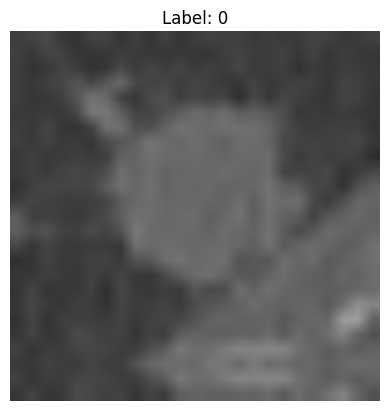

In [19]:
# Adjust transform (remove normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = TumorDataset(image_data_path, labels_df, transform=transform)
num_samples_to_display = 5
# Visualize without denormalization
for i in range(num_samples_to_display):
    image, label, _ = dataset[i]
    plt.imshow(image.permute(1, 2, 0).numpy())
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Data Splitting

## Using stratified split

In [20]:
"""from sklearn.model_selection import train_test_split

# Split the patient IDs into training and temporary sets (80% - 20%)
train_ids, temp_ids, train_labels, temp_labels = train_test_split(
    labels_df['UID'], labels_df['MUT_STATUS'],
    test_size=0.2,
    stratify=labels_df['MUT_STATUS'],
    random_state=42
)

# Further split the temporary set into validation and testing sets (50% - 50% of the 20% => 10% - 10% of the total)
val_ids, test_ids, val_labels, test_labels = train_test_split(
    temp_ids, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# Now, you have train_ids, val_ids, and test_ids which are patient IDs for training, validation, and testing sets respectively.
"""

"from sklearn.model_selection import train_test_split\n\n# Split the patient IDs into training and temporary sets (80% - 20%)\ntrain_ids, temp_ids, train_labels, temp_labels = train_test_split(\n    labels_df['UID'], labels_df['MUT_STATUS'], \n    test_size=0.2, \n    stratify=labels_df['MUT_STATUS'], \n    random_state=42\n)\n\n# Further split the temporary set into validation and testing sets (50% - 50% of the 20% => 10% - 10% of the total)\nval_ids, test_ids, val_labels, test_labels = train_test_split(\n    temp_ids, temp_labels, \n    test_size=0.5, \n    stratify=temp_labels, \n    random_state=42\n)\n\n# Now, you have train_ids, val_ids, and test_ids which are patient IDs for training, validation, and testing sets respectively.\n"

In [21]:
"""train_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(train_ids)], transform=transform)
val_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(val_ids)], transform=transform)
test_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(test_ids)], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
"""

"train_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(train_ids)], transform=transform)\nval_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(val_ids)], transform=transform)\ntest_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(test_ids)], transform=transform)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)\nval_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)\ntest_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)\n"

In [22]:
"""# 1. Check lengths of datasets
print(f"Original dataset length: {len(labels_df)}")
print(f"Training set length: {len(train_dataset)}")
print(f"Validation set length: {len(val_dataset)}")
print(f"Test set length: {len(test_dataset)}")
print(f"Total of train, val, and test: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

# 2. Inspect class distributions
def get_class_distribution(dataset):
    return pd.Series([label for _, label, _ in dataset]).value_counts(normalize=True)


print("\nClass distribution in original dataset:")
print(labels_df['MUT_STATUS'].value_counts(normalize=True))
print("\nClass distribution in training set:")
print(get_class_distribution(train_dataset))
print("\nClass distribution in validation set:")
print(get_class_distribution(val_dataset))
print("\nClass distribution in test set:")
print(get_class_distribution(test_dataset))

# 3. Visualize some images from each split
def visualize_images(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax in axes:
        image, label, _ = dataset[np.random.randint(len(dataset))]
        ax.imshow(image.permute(1, 2, 0))  # Convert CxHxW to HxWxC for visualization
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

visualize_images(train_dataset, "Training Data")
visualize_images(val_dataset, "Validation Data")
visualize_images(test_dataset, "Test Data")

# 4. Check for overlaps
train_ids = set([dataset[i][2] for i in range(len(dataset))])
val_ids = set([val_dataset[i][2] for i in range(len(val_dataset))])
test_ids = set([test_dataset[i][2] for i in range(len(test_dataset))])

overlap_train_val = train_ids.intersection(val_ids)
overlap_train_test = train_ids.intersection(test_ids)
overlap_val_test = val_ids.intersection(test_ids)

print(f"Overlap between train and val: {overlap_train_val}")
print(f"Overlap between train and test: {overlap_train_test}")
print(f"Overlap between val and test: {overlap_val_test}")
"""

'# 1. Check lengths of datasets\nprint(f"Original dataset length: {len(labels_df)}")\nprint(f"Training set length: {len(train_dataset)}")\nprint(f"Validation set length: {len(val_dataset)}")\nprint(f"Test set length: {len(test_dataset)}")\nprint(f"Total of train, val, and test: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")\n\n# 2. Inspect class distributions\ndef get_class_distribution(dataset):\n    return pd.Series([label for _, label, _ in dataset]).value_counts(normalize=True)\n\n\nprint("\nClass distribution in original dataset:")\nprint(labels_df[\'MUT_STATUS\'].value_counts(normalize=True))\nprint("\nClass distribution in training set:")\nprint(get_class_distribution(train_dataset))\nprint("\nClass distribution in validation set:")\nprint(get_class_distribution(val_dataset))\nprint("\nClass distribution in test set:")\nprint(get_class_distribution(test_dataset))\n\n# 3. Visualize some images from each split\ndef visualize_images(dataset, title):\n    fig, axes = 

In [23]:
"""# Ensure there's no overlap between the different datasets
assert set(train_ids).intersection(val_ids) == set(), "Overlap between training and validation sets!"
assert set(train_ids).intersection(test_ids) == set(), "Overlap between training and test sets!"
assert set(val_ids).intersection(test_ids) == set(), "Overlap between validation and test sets!"
"""

'# Ensure there\'s no overlap between the different datasets\nassert set(train_ids).intersection(val_ids) == set(), "Overlap between training and validation sets!"\nassert set(train_ids).intersection(test_ids) == set(), "Overlap between training and test sets!"\nassert set(val_ids).intersection(test_ids) == set(), "Overlap between validation and test sets!"\n'

The stratified split is somehow having overlap.so using StratifiedGroupKFold

In [24]:
from sklearn.model_selection import StratifiedGroupKFold

# Prepare the data
X = labels_df['UID'].values
y = labels_df['MUT_STATUS'].values
groups = labels_df['UID'].values  # The patients are their own groups

# Create an instance of StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)

# Get the train and temp indices from the first split
train_indices, temp_indices = next(sgkf.split(X, y, groups))

# Extract training data
train_ids = X[train_indices]
train_labels = y[train_indices]

# Further split the temporary set into validation and test using the same approach
val_indices, test_indices = next(sgkf.split(X[temp_indices], y[temp_indices], groups[temp_indices]))

# Extract validation and test data
val_ids = X[temp_indices][val_indices]
val_labels = y[temp_indices][val_indices]
test_ids = X[temp_indices][test_indices]
test_labels = y[temp_indices][test_indices]

# Now, you have train_ids, val_ids, and test_ids which are patient IDs for training, validation, and testing sets respectively.

train_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(train_ids)], transform=transform)
val_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(val_ids)], transform=transform)
test_dataset = TumorDataset(image_data_path, labels_df[labels_df['UID'].isin(test_ids)], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [25]:
# Ensure there's no overlap between the different datasets
assert set(train_ids).intersection(val_ids) == set(), "Overlap between training and validation sets!"
assert set(train_ids).intersection(test_ids) == set(), "Overlap between training and test sets!"
assert set(val_ids).intersection(test_ids) == set(), "Overlap between validation and test sets!"

print("No overlaps found!")


No overlaps found!


# Model Architecture
Tumor Detection using Transfer Learning with ResNet18
1. Introduction

In this task of detecting tumors from medical images, I aimed to classify patients based on the presence (or absence) of specific tumor mutations. Given the time constraints and the nature of medical imaging data, I chose a transfer learning approach using a pre-trained model.

2. Rationale Behind Transfer Learning

Data Constraints: Medical imaging datasets are typically smaller in size than other datasets. Training deep neural networks from scratch on such datasets can often result in overfitting.
Benefit of Pre-trained Knowledge: Models like ResNet18 are trained on vast datasets (like ImageNet) and have gleaned significant features from a variety of images, which can be advantageous for my task.
Efficiency: With the time constraint of 45-60 minutes for the coding challenge, starting from scratch isn't an option. Transfer learning offers rapid convergence and requires fewer parameters to be trained, which is time-saving.
3. Why ResNet18?

Model Complexity: ResNet18 is a good compromise between model depth and computational cost. It's sufficiently deep to recognize intricate patterns but isn't as computationally demanding as its deeper counterparts like ResNet101 or ResNet152.
Performance Track Record: ResNet architectures, even the more streamlined ones, have consistently shown effectiveness across various image classification tasks.
4. Adapting the Model for the Task

Leveraging Pre-trained Weights: I froze all layers of the ResNet18 model, except the final layer, to make use of the existing features and ensured only the last layer gets updated for the task at hand.
Customizing the Output Layer: I adjusted the final layer of the model to consist of a single output neuron to adapt it for the binary classification at hand.
5. Handling Data Imbalance

The dataset showcased an imbalanced class distribution. Consequently, I decided that relying solely on accuracy might be misleading. Instead, I'll place importance on metrics like the F1-score, AUC-ROC, precision, and recall during model evaluation.

6. Conclusion and Next Steps

Employing transfer learning with ResNet18 provides an efficient and potentially effective method to address the tumor detection problem within the set constraints. While the current approach leverages a single image per patient, exploring techniques to utilize all available images for each patient is a viable avenue for future improvement.



In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, roc_auc_score


In [27]:
# Load pre-trained ResNet18 model + higher level layers
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer (for fine-tuning)
for param in model.layer4[1].parameters():
    param.requires_grad = True

# Modify the final layer to match the number of classes (in your case, 2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification hence, one neuron with sigmoid activation.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [31]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels, _ in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 0.7700
Epoch 2/10, Loss: 0.1031
Epoch 3/10, Loss: 0.0856
Epoch 4/10, Loss: 0.0208
Epoch 5/10, Loss: 0.0133
Epoch 6/10, Loss: 0.0132
Epoch 7/10, Loss: 0.0065
Epoch 8/10, Loss: 0.0055
Epoch 9/10, Loss: 0.0039
Epoch 10/10, Loss: 0.0044


In [32]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels, _ in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).round()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


              precision    recall  f1-score   support

     Class 0       0.83      1.00      0.91        15
     Class 1       0.00      0.00      0.00         3

    accuracy                           0.83        18
   macro avg       0.42      0.50      0.45        18
weighted avg       0.69      0.83      0.76        18



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from sklearn.metrics import f1_score

f1 = f1_score(all_labels, all_preds)
print(f"F1 Score: {f1:.4f}")



F1 Score: 0.0000


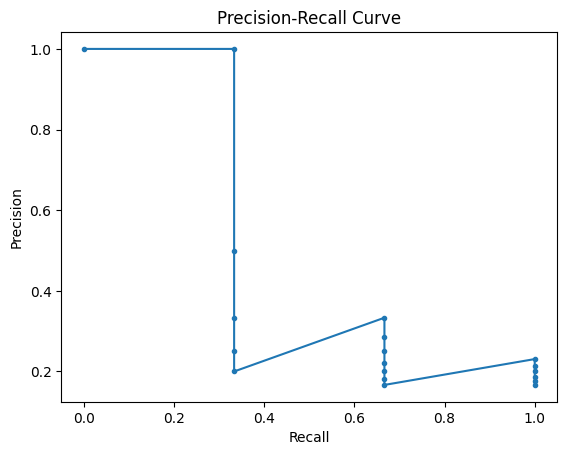

In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Since the model outputs logits, you need to apply sigmoid to get the probabilities
# Assuming `all_outputs` contains the raw output (logit) of the model for all samples
all_outputs = []
with torch.no_grad():
    for images, labels, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        all_outputs.extend(outputs.cpu().numpy())

probabilities = 1 / (1 + np.exp(-np.array(all_outputs)))  # Apply sigmoid

precision, recall, _ = precision_recall_curve(all_labels, probabilities)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


In [36]:
from sklearn.metrics import average_precision_score

auc_pr = average_precision_score(all_labels, probabilities)
print(f"AUC-PR: {auc_pr:.4f}")



AUC-PR: 0.5214
